# Notebook d'entrainement d'un modèle BERT à l'analyse de sentiment


In [ ]:
!pip install seaborn
!pip install sklearn
!pip install tensorflow
!pip install transformers
!pip install sentencepiece

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import metrics
from transformers import TFCamembertForSequenceClassification
import transformers.models.camembert.tokenization_camembert as tk

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices() # permet de vérifier que tensorflow détecte bien la carte graphique

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16696533386733467777,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 2249614951
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3219963744116640372
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"]

### Paramétrage de l'entrainement

In [3]:
TRAIN_ON_ALLOCINE = "ALLOCINE"
TRAIN_ON_TWEETS = "TWEETS"

In [4]:
model_name = "jplu/tf-camembert-base"
TRAIN_SET = TRAIN_ON_TWEETS

n_train = 10000
n_val = 1000
n_test = 1000

epochs = 10
batch_size = 4
lr = 4e-7

### Récupération des jeux de données

In [5]:
MAX_SEQ_LEN = 45

if(TRAIN_SET == TRAIN_ON_TWEETS):
    dataset_tweets = pd.read_csv("./data/french_tweets.csv").sample(n=(n_train+n_val+n_test))
    tweets = dataset_tweets['text'].values.tolist()
    sentiments = dataset_tweets['label'].values.tolist()

    msg_train = tweets[:n_train]
    msg_val = tweets[n_train:n_train+n_val]
    msg_test = tweets[n_train+n_val:]

    labels_train = sentiments[:n_train]
    labels_val = sentiments[n_train:n_train+n_val]
    labels_test = sentiments[n_train+n_val:]
else:
    dataset = pd.read_pickle("./data/allocine_dataset.pickle")

    msg_train = np.array(dataset["train_set"]['review'])[:n_train]
    msg_val = np.array(dataset["val_set"]['review'])[:n_val]
    msg_test = np.array(dataset["test_set"]['review'])[:n_test]

    labels_train = dataset["train_set"]['polarity'][:n_train]
    labels_val = dataset["val_set"]['polarity'][:n_val]
    labels_test = dataset["test_set"]['polarity'][:n_test]
    MAX_SEQ_LEN = 200

print(f'Nombre de tweets + : {labels_train.count(1)}  |   Nombre de tweet - : {labels_train.count(0)}')
print(f'Training: {len(msg_train)}   |   Validation: {len(msg_val)}    |   Test: {len(msg_test)}')

Nombre de tweets + : 5037  |   Nombre de tweet - : 4963
Training: 10000   |   Validation: 1000    |   Test: 1000


### Encodage des données pour l'entrainement

In [6]:
tokenizer = tk.CamembertTokenizer.from_pretrained(model_name,do_lower_case=True)
assert tokenizer != None

In [7]:
def encode_reviews(tokenizer, reviews, max_length):
    token_ids = np.zeros(shape=(len(reviews), max_length),
                         dtype=np.int32)
    for i, review in enumerate(reviews):
        encoded = tokenizer.encode(review, max_length=max_length)
        token_ids[i, 0:len(encoded)] = encoded
    attention_mask = (token_ids != 0).astype(np.int32)
    return {"input_ids": token_ids, "attention_mask": attention_mask}

In [8]:
encoded_train = encode_reviews(tokenizer, msg_train, MAX_SEQ_LEN)
encoded_valid = encode_reviews(tokenizer, msg_val, MAX_SEQ_LEN)
encoded_test = encode_reviews(tokenizer, msg_test, MAX_SEQ_LEN)

y_train = np.array(labels_train)
y_val = np.array(labels_val)
y_test = np.array(labels_test)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


### Récupération du modèle pré-entrainé

In [9]:
model = TFCamembertForSequenceClassification.from_pretrained(model_name)

opt = tf.keras.optimizers.Adam(learning_rate=lr, epsilon=1e-08)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)    

model.compile(optimizer=opt, loss=loss_fn, metrics=['accuracy'])

All model checkpoint layers were used when initializing TFCamembertForSequenceClassification.

Some layers of TFCamembertForSequenceClassification were not initialized from the model checkpoint at jplu/tf-camembert-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Entrainement

In [10]:
history = model.fit(
    encoded_train, y_train,
    epochs=epochs, 
    batch_size=batch_size, 
    validation_data=(encoded_valid, y_val), 
    verbose=1, 
    shuffle=True
)

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AU

### Affichage de l'évolution de l'entrainement 

In [11]:
def plot_loss_acc(history):
    """Plot training and (optionally) validation loss and accuracy"""

    loss = history.history['loss']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(10, 10))

    plt.subplot(2, 1, 1)
    plt.plot(epochs, loss, '.--', label='Training loss')
    final_loss = loss[-1]
    title = 'Training loss: {:.4f}'.format(final_loss)
    plt.ylabel('Loss')
    if 'val_loss' in history.history:
        val_loss = history.history['val_loss']
        plt.plot(epochs, val_loss, 'o-', label='Validation loss')
        final_val_loss = val_loss[-1]
        title += ', Validation loss: {:.4f}'.format(final_val_loss)
    plt.title(title)
    plt.legend()

    acc = history.history['accuracy']

    plt.subplot(2, 1, 2)
    plt.plot(epochs, acc, '.--', label='Training acc')
    final_acc = acc[-1]
    title = 'Training accuracy: {:.2f}%'.format(final_acc * 100)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    if 'val_accuracy' in history.history:
        val_acc = history.history['val_accuracy']
        plt.plot(epochs, val_acc, 'o-', label='Validation acc')
        final_val_acc = val_acc[-1]
        title += ', Validation accuracy: {:.2f}%'.format(final_val_acc * 100)
    plt.title(title)
    plt.legend()


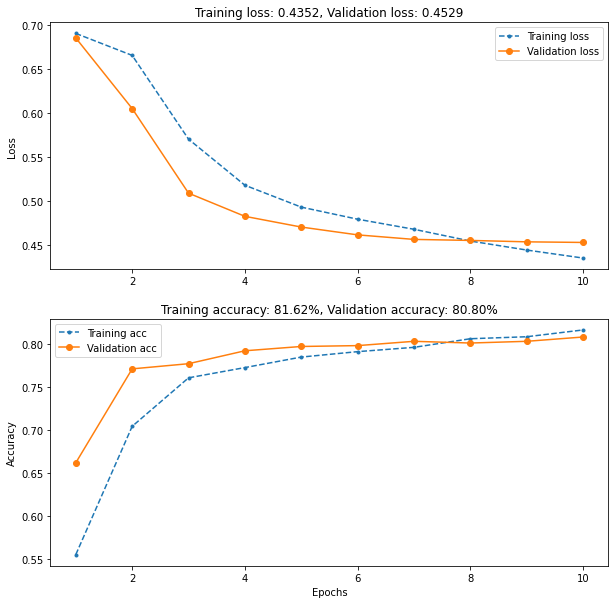

In [12]:
plot_loss_acc(history)

In [13]:
def prediction(x, mdl=model):
    scores = mdl.predict(x)
    y_pred = np.argmax(scores['logits'], axis=1)
    return y_pred

### Evaluation du modèle
Avec les jeux de données d'entrainement

In [14]:
def evaluation(y,y_pred,graph=True):
    TP = np.count_nonzero(y*y_pred)
    TN = np.count_nonzero((y-1)*(y_pred-1))
    FN = np.count_nonzero((y-1)*y_pred)
    FP = np.count_nonzero(y*(y_pred-1))
    tot = TP+TN+FN+FP

    accuracy = metrics.accuracy_score(y, y_pred)
    f1_score = metrics.f1_score(y, y_pred)
    conf_mx = metrics.confusion_matrix(y, y_pred)

    conf_matrix = [[TN,FN],[FP,TP]]
    if((TP+FP) != 0 and (TP+FN) != 0):
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        f1 = 2 * precision * recall / (precision + recall)
    else:
        precision = accuracy
        recall = -1
        f1 = f1_score

    print(f"Precision: {round(100 * precision,2)}")
    print(f"Rappel: {round(100 * recall,2)}")
    print(f"F-score: {round(100 * f1,2)}")
    print(f"%bon: {round(100*(TP+TN)/tot,2)} - %faux: {round(100*(FP+FN)/tot,2)}")
    print(f"Matrice: {conf_matrix}")
    if(graph):
        sns.heatmap(conf_matrix)
    return [precision,recall,f1_score,conf_matrix]

Precision: 79.19
Rappel: 77.11
F-score: 78.14
%bon: 77.0 - %faux: 23.0
Matrice: [[359, 122], [108, 411]]


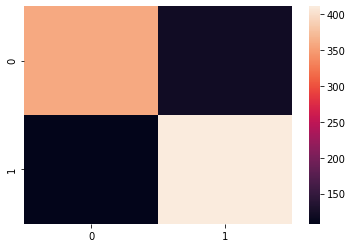

In [15]:
y_pred = prediction(encoded_test)
[precision,recall,f1_score,conf_matrix] = evaluation(y_test,y_pred)

### Sauvegarde des poids après entrainement

In [16]:
model_weight_name = f"./models_weights/f1{round(100*f1_score)}_count{len(msg_train)}_epo{epochs}_batch{batch_size}.h5"
model.save_weights(model_weight_name)

### Evaluation avec des messages de conversation annotés à la main

In [17]:
data_messages = pd.read_csv("./messages/messages0.csv")
msg_labels = data_messages['sentiments'].values.tolist()
msg = data_messages['messages'].values.tolist()

encoded_msg = encode_reviews(tokenizer, msg, 200)
y_msg = np.array(msg_labels)

Precision: 80.47
Rappel: 72.34
F-score: 76.19
%bon: 69.42 - %faux: 30.58
Matrice: [[57, 52], [33, 136]]


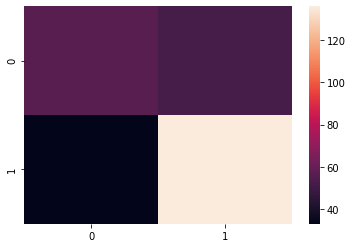

In [18]:
y_pred = prediction(encoded_msg)
_ = evaluation(y_msg,y_pred)